In [196]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [197]:
import os

# Use raw string to avoid backslash issues
input_path = r"D:\codes\Flood-Detection-Using-Deep-Learning-Model-From-Satellite-Images-\FloodDataset"

def print_file_sizes(input_path, subset):
	path = os.path.join(input_path, subset)
	print(f"\nSubset: {subset}")
	print("-" * 50)

	if not os.path.exists(path):
		print("❌ Path does not exist:", path)
		return

	total_files = 0
	total_size = 0.0

	for subfolder in os.listdir(path):
		subpath = os.path.join(path, subfolder)
		if not os.path.isdir(subpath):
			continue

		files = [
			os.path.join(subpath, f)
			for f in os.listdir(subpath)
			if os.path.isfile(os.path.join(subpath, f))
		]
		size_mb = round(sum(os.path.getsize(f) for f in files) / 1e6, 2)
		count = len(files)
		total_files += count
		total_size += size_mb

		print(f"{subfolder:<20} {count:>5} files | {size_mb:>8} MB")

	print("-" * 50)
	print(f"Total: {total_files} files | {round(total_size, 2)} MB\n")

print_file_sizes(input_path, 'test')
print_file_sizes(input_path, 'test_another')
print_file_sizes(input_path, 'validation_another')



Subset: test
--------------------------------------------------
damage                  82 files |     1.25 MB
notdamage              139 files |     2.37 MB
--------------------------------------------------
Total: 221 files | 3.62 MB


Subset: test_another
--------------------------------------------------
damage                  44 files |     0.72 MB
no_damage               44 files |     0.72 MB
--------------------------------------------------
Total: 88 files | 1.44 MB


Subset: validation_another
--------------------------------------------------
damage                  78 files |      1.2 MB
notdamage              139 files |     2.37 MB
--------------------------------------------------
Total: 217 files | 3.57 MB



In [198]:
from pathlib import Path
import pandas as pd
import random
import os

# Root dataset path
input_path = Path(r"D:\codes\Flood-Detection-Using-Deep-Learning-Model-From-Satellite-Images-\FloodDataset")

# Function to generate random coordinates
def random_coords():
    lon = round(random.uniform(68.0, 97.0), 4)   # India longitude approx range
    lat = round(random.uniform(8.0, 37.0), 4)    # India latitude approx range
    return f"{lon}_{lat}"

# Find all JPG files
image_paths = list(input_path.rglob("*.jpg"))

renamed_files = []
for p in image_paths:
    new_name = random_coords() + ".jpg"
    new_path = p.parent / new_name

    # Avoid overwriting files by regenerating if name already exists
    while new_path.exists():
        new_name = random_coords() + ".jpg"
        new_path = p.parent / new_name

    os.rename(p, new_path)
    renamed_files.append(new_path)

# Build dataframe
image_df = pd.DataFrame({
    'path': [str(p) for p in renamed_files],
    'subset': [p.parent.parent.stem for p in renamed_files],
    'damage_type': [p.parent.stem for p in renamed_files],
    'location': [p.stem for p in renamed_files],
})

# Extract lon/lat from filename
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[1]))

print("✅ Renaming complete.")
print("Total images renamed:", len(image_df))
print(image_df.head())

# Optionally save to CSV for reference
image_df.to_csv("renamed_image_data.csv", index=False)


✅ Renaming complete.
Total images renamed: 743
                                                path subset damage_type  \
0  D:\codes\Flood-Detection-Using-Deep-Learning-M...   test      damage   
1  D:\codes\Flood-Detection-Using-Deep-Learning-M...   test      damage   
2  D:\codes\Flood-Detection-Using-Deep-Learning-M...   test      damage   
3  D:\codes\Flood-Detection-Using-Deep-Learning-M...   test      damage   
4  D:\codes\Flood-Detection-Using-Deep-Learning-M...   test      damage   

          location      lon      lat  
0  69.6329_30.0271  69.6329  30.0271  
1   89.0157_9.4676  89.0157   9.4676  
2  84.6977_15.4436  84.6977  15.4436  
3  93.9251_31.3813  93.9251  31.3813  
4  86.3343_10.5624  86.3343  10.5624  


Traning Labels


In [199]:
# find all .jpg files under the dataset root (recursively)
image_paths = list(Path(input_path).rglob('*.jpg'))
image_df = pd.DataFrame({'path': image_paths})

image_df['damage' ] = image_df['path'].map(lambda x: x.parent.stem)
image_df['date_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location' ] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location' ].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df['path'] = image_df['path'].map(lambda x: str(x)) # convert the path back to a string

image_df.head()

path  damage date_split  \
0  D:\codes\Flood-Detection-Using-Deep-Learning-M...  damage       test   
1  D:\codes\Flood-Detection-Using-Deep-Learning-M...  damage       test   
2  D:\codes\Flood-Detection-Using-Deep-Learning-M...  damage       test   
3  D:\codes\Flood-Detection-Using-Deep-Learning-M...  damage       test   
4  D:\codes\Flood-Detection-Using-Deep-Learning-M...  damage       test   

          location      lon      lat  
0  68.2094_29.9284  68.2094  29.9284  
1   68.2335_9.3532  68.2335   9.3532  
2  68.3329_23.8232  68.3329  23.8232  
3  68.8122_22.0238  68.8122  22.0238  
4  69.0859_13.3925  69.0859  13.3925

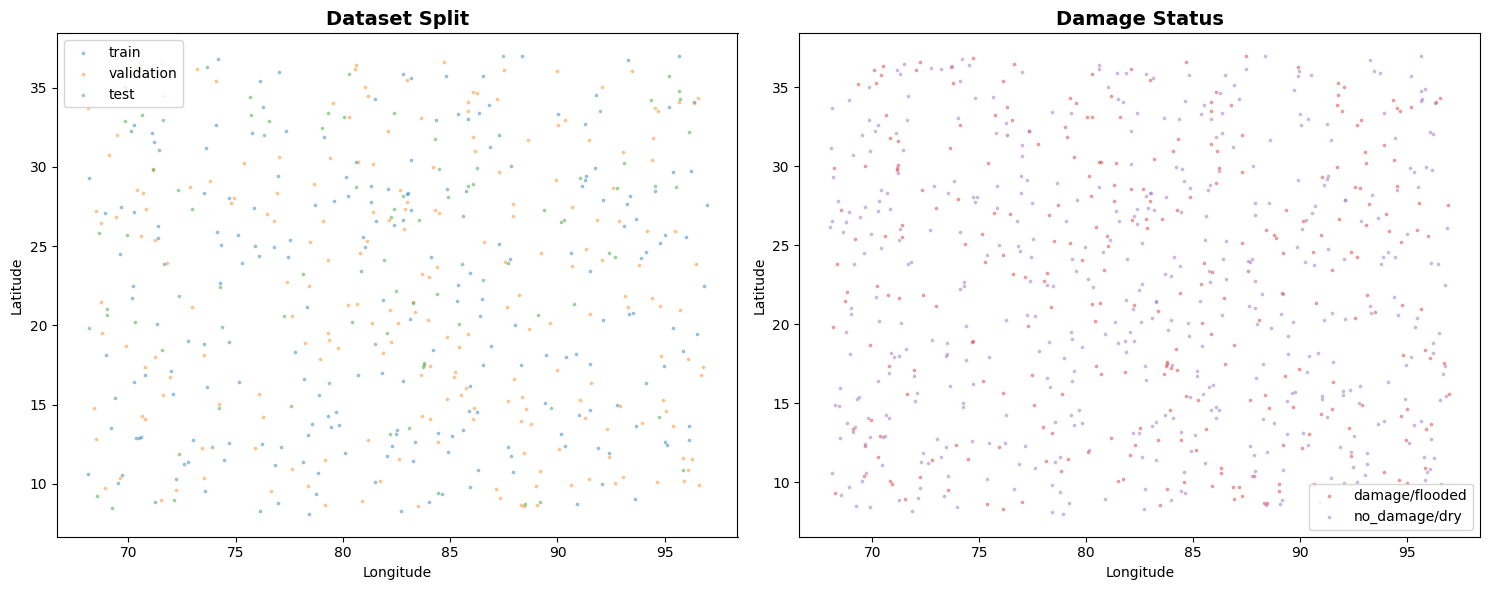

In [200]:
import matplotlib.pyplot as plt

# Create two subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

s = 3          # dot size
alpha = 0.35   # transparency

# ------------------ Data Splits ------------------
# Make sure the column name matches your DataFrame (you used 'date_split' earlier)
image_df_train = image_df[image_df['date_split'] == 'train_another'].copy()
image_df_val = image_df[image_df['date_split'] == 'validation_another'].copy()
image_df_test = image_df[image_df['date_split'] == 'test_another'].copy()

# Sort to ensure reproducibility
for df in [image_df_train, image_df_val, image_df_test]:
    df.sort_values('lat', inplace=True)
    df.reset_index(drop=True, inplace=True)

# Scatter plot for dataset splits
ax[0].scatter(image_df_train['lon'], image_df_train['lat'], color='C0', s=s, alpha=alpha, label='train')
ax[0].scatter(image_df_val['lon'], image_df_val['lat'], color='C1', s=s, alpha=alpha, label='validation')
ax[0].scatter(image_df_test['lon'], image_df_test['lat'], color='C2', s=s, alpha=alpha, label='test')

ax[0].set_title('Dataset Split', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# ------------------ Damage Status ------------------
# Make sure 'damage' column exists and contains correct values
image_df_dmg = image_df[image_df['damage'].str.lower().isin(['damage', 'flooded'])].copy()
image_df_nodmg = image_df[~image_df['damage'].str.lower().isin(['damage', 'flooded'])].copy()

for df in [image_df_dmg, image_df_nodmg]:
    df.reset_index(drop=True, inplace=True)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C3', s=s, alpha=alpha, label='damage/flooded')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C4', s=s, alpha=alpha, label='no_damage/dry')

ax[1].set_title('Damage Status', fontsize=14, fontweight='bold')
ax[1].legend()
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


Training images

In [201]:
import cv2

img = cv2.imread(image_df['path'][0], cv2.IMREAD_UNCHANGED) 
np.shape(img)

(150, 200, 3)

In [202]:
type(img[0,0,0])

numpy.uint8

In [203]:
np.min(img[:,:,:])

np.uint8(0)

In [204]:
np.max(img[:,:,:])

np.uint8(228)

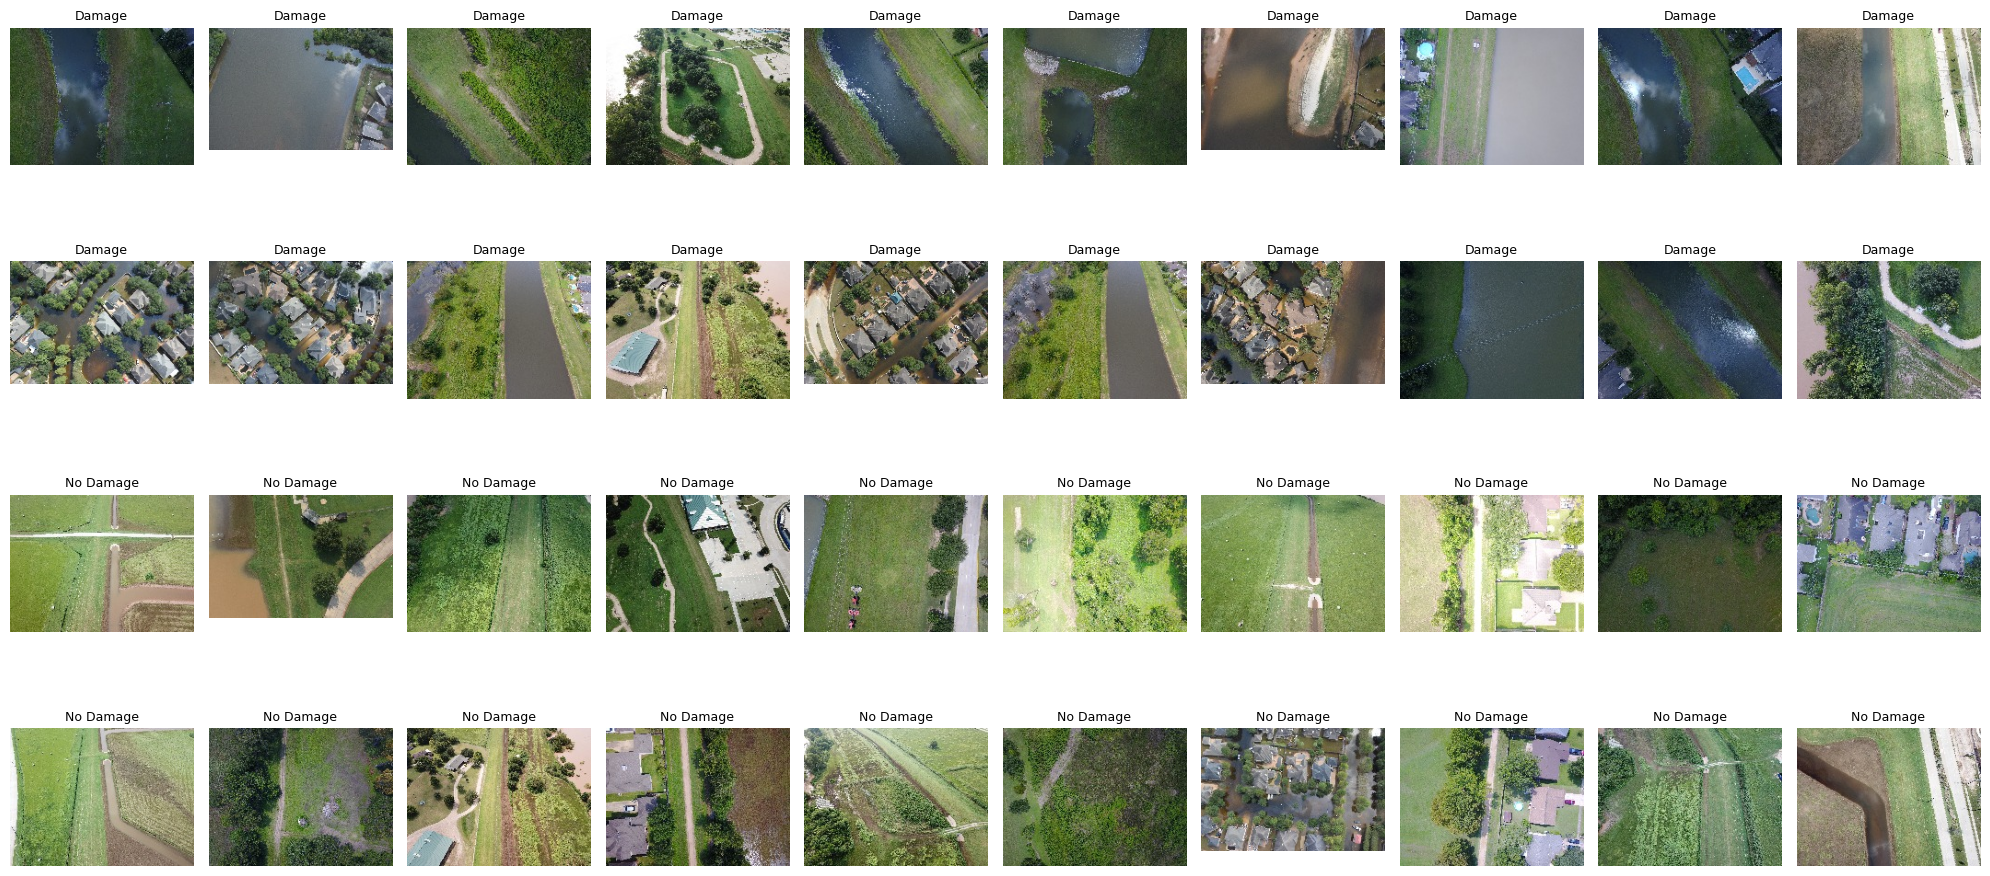

In [205]:
import matplotlib.pyplot as plt
import cv2

# Create a 4x10 grid (40 subplots)
fig, ax = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(20, 10))
ax = ax.flatten()

# Determine how many images we actually have
num_damage = min(20, len(image_df_dmg))
num_nodamage = min(20, len(image_df_nodmg))

# Show 20 damage samples
for i in range(num_damage):
    img = cv2.imread(image_df_dmg['path'].iloc[i])
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img_rgb)
    ax[i].set_title('Damage', fontsize=9)
    ax[i].axis('off')

# Show 20 no-damage samples (next 20 positions)
for i in range(num_nodamage):
    idx = i + num_damage  # start after previous ones
    img = cv2.imread(image_df_nodmg['path'].iloc[i])
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[idx].imshow(img_rgb)
    ax[idx].set_title('No Damage', fontsize=9)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()


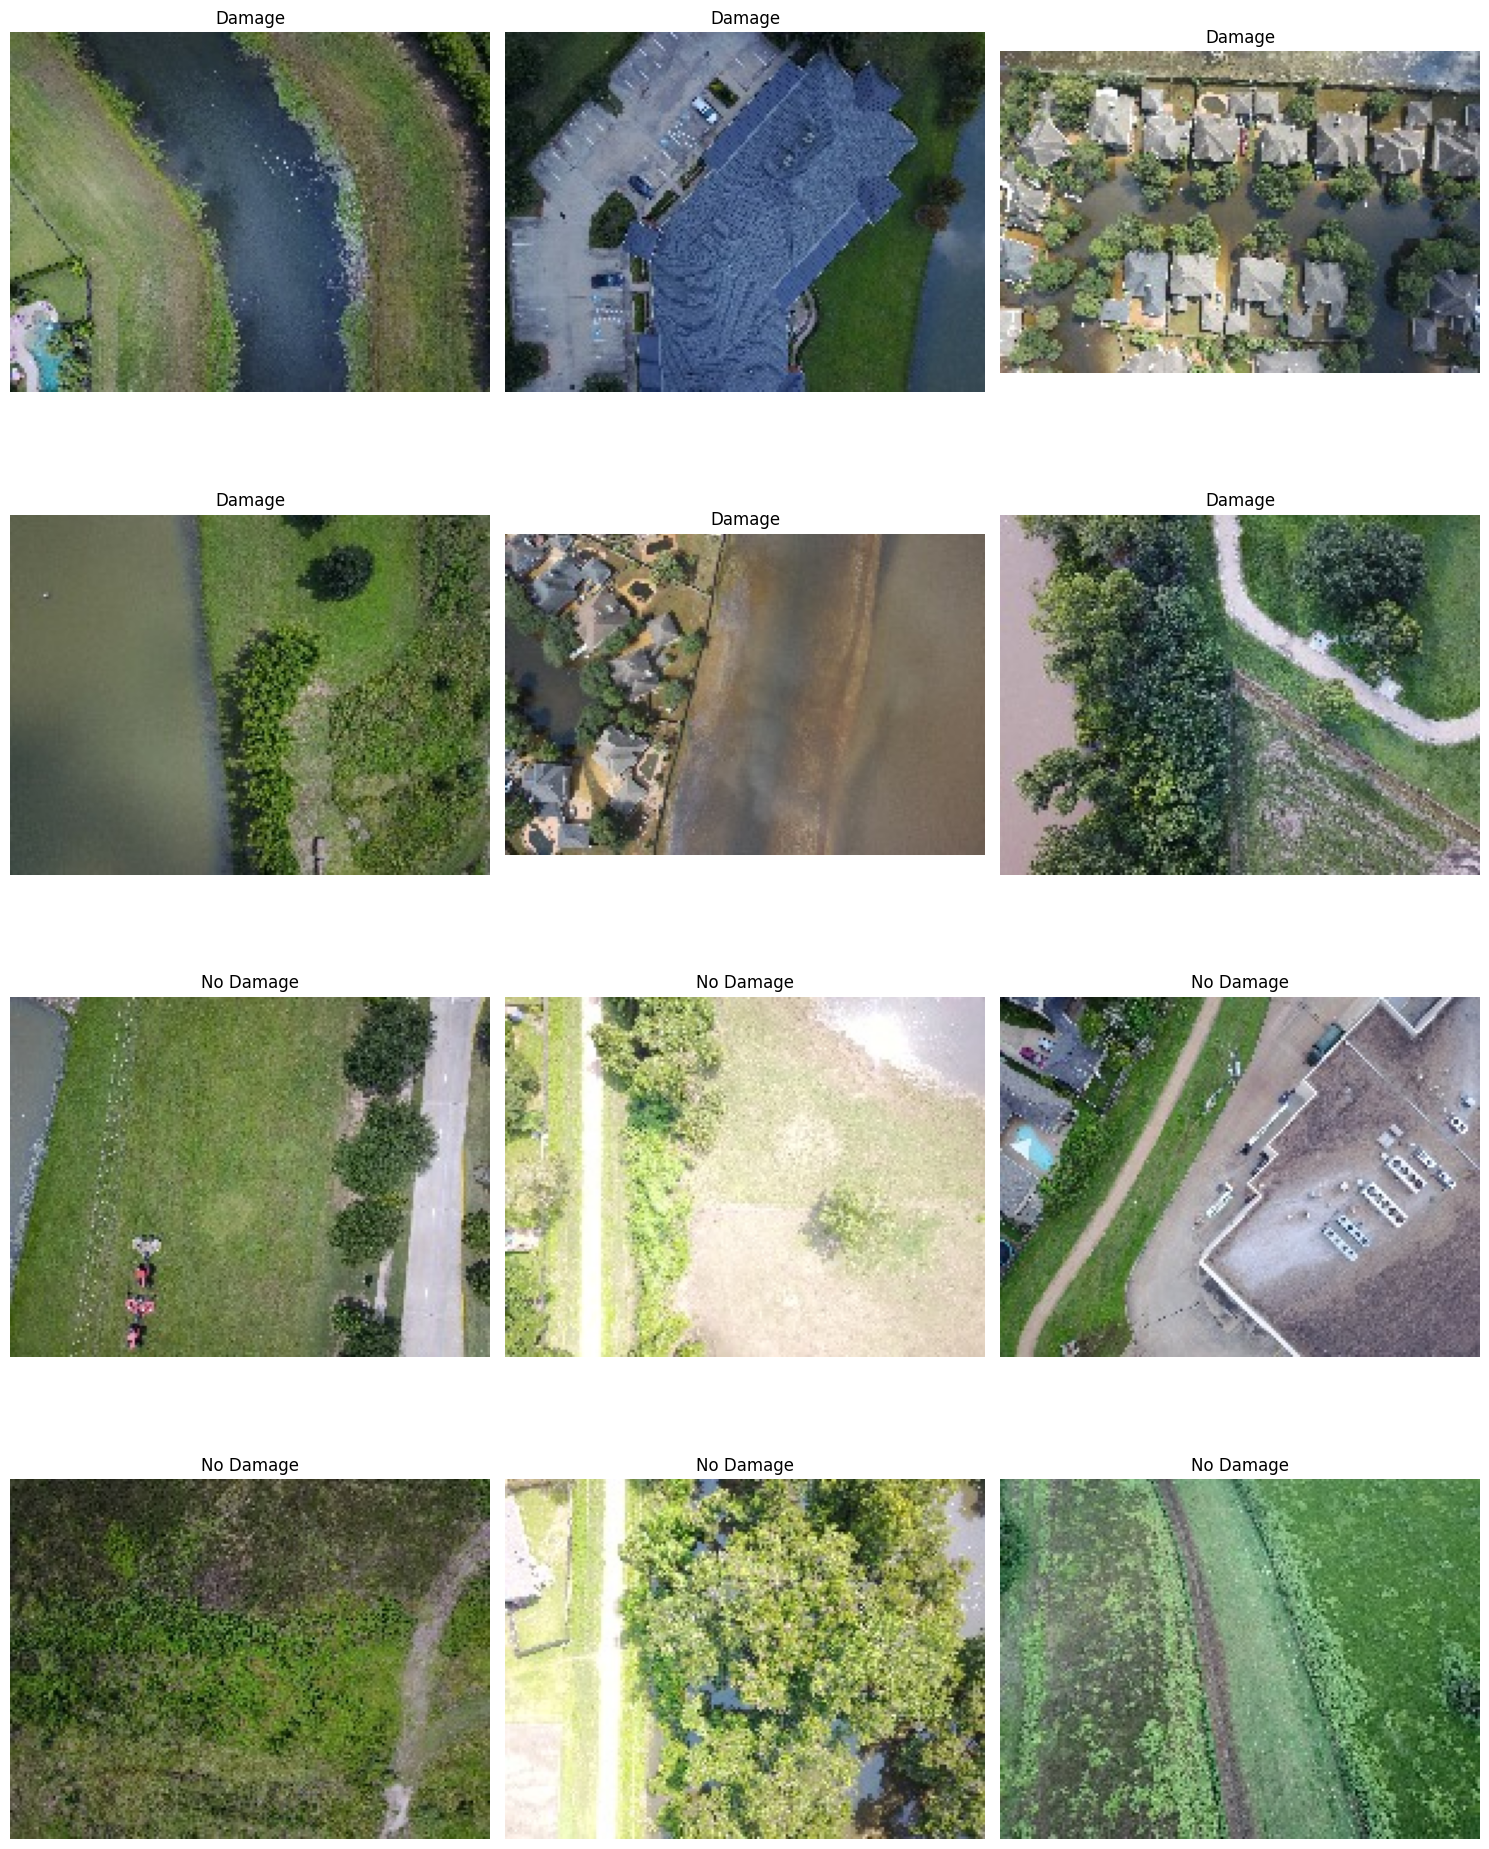

In [206]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Make sure you have enough samples
num_dmg = len(image_df_dmg)
num_nodmg = len(image_df_nodmg)

# Pick 6 random indices (or all if fewer than 6)
selected_dmg = np.random.choice(num_dmg, size=min(6, num_dmg), replace=False)
selected_nodmg = np.random.choice(num_nodmg, size=min(6, num_nodmg), replace=False)

# Create figure and axes
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
ax = ax.flatten()

# Show damage images
for i, idx in enumerate(selected_dmg):
    img = cv2.imread(str(image_df_dmg['path'].iloc[idx]), cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('Damage')
    ax[i].axis('off')

# Show no-damage images
for i, idx in enumerate(selected_nodmg):
    img = cv2.imread(str(image_df_nodmg['path'].iloc[idx]), cv2.IMREAD_UNCHANGED)
    ax[i + 6].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i + 6].set_title('No Damage')
    ax[i + 6].axis('off')

# Adjust layout
fig.tight_layout()
plt.show()


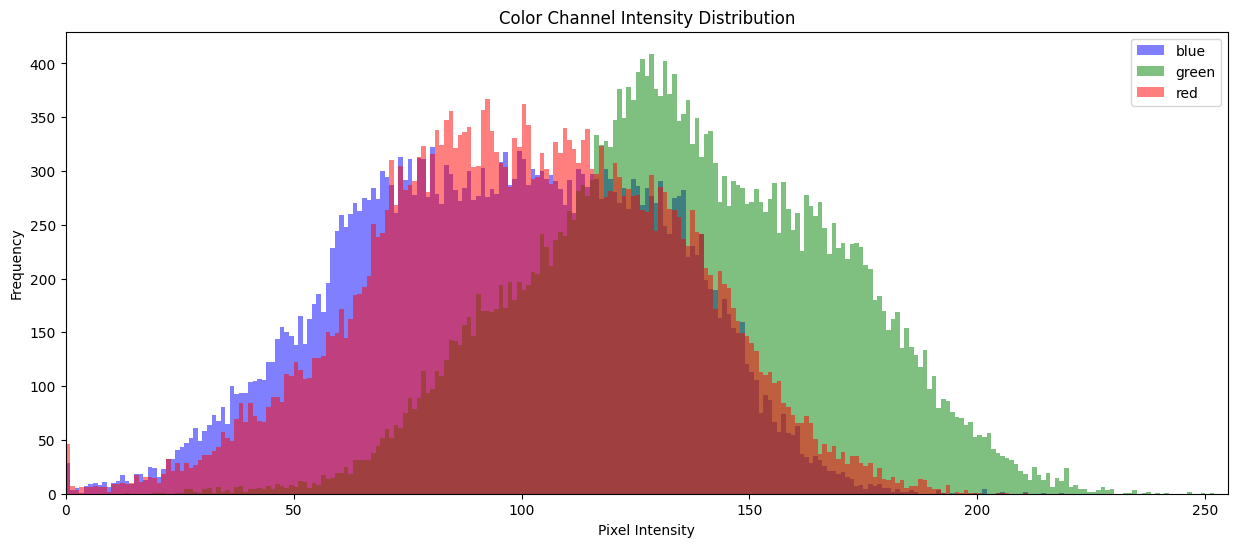

In [207]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read an image (make sure you have 'img' defined or use a sample)
# Example: img = cv2.imread(str(image_df_dmg['path'].iloc[0]), cv2.IMREAD_UNCHANGED)
# Convert to RGB if needed
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

jpg_channels = ['blue', 'green', 'red']
jpg_channel_colors = ['b', 'g', 'r']

fig, ax = plt.subplots(figsize=(15, 6))

for i in range(len(jpg_channels)):
    ax.hist(img[:, :, i].flatten(),
            bins=np.arange(256),
            label=jpg_channels[i],
            color=jpg_channel_colors[i],
            alpha=0.5)

ax.legend()
ax.set_xlim(0, 255)
ax.set_title("Color Channel Intensity Distribution")
ax.set_xlabel("Pixel Intensity")
ax.set_ylabel("Frequency")

plt.show()


In [208]:
import tensorflow as tf
tf.__version__

'2.19.0'

In [209]:
# paths
train_path = image_df_train['path'].copy().values
val_path = image_df_val['path'].copy().values
test_path = image_df_test['path'].copy().values

# Labels
train_labels = np.zeros(len(image_df_train), dtype=np.int8)
train_labels[image_df_train['damage'].values == 'damage'] = 1

val_labels = np.zeros(len(image_df_val), dtype=np.int8)
val_labels[image_df_val['damage'].values == 'damage'] = 1

test_labels = np.zeros(len(image_df_test), dtype=np.int8)
test_labels[image_df_test['damage'].values == 'damage' ] = 1

In [210]:
import tensorflow as tf

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_path, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_path, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_path, test_labels))

# Display first 5 samples from training set
for path, label in train_ds.take(5):
    print("path  :", path.numpy().decode('utf-8'))
    print("label :", label.numpy())


path  : D:\codes\Flood-Detection-Using-Deep-Learning-Model-From-Satellite-Images-\FloodDataset\train_another\notdamage\78.4126_8.1077.jpg
label : 0
path  : D:\codes\Flood-Detection-Using-Deep-Learning-Model-From-Satellite-Images-\FloodDataset\train_another\notdamage\82.7206_8.2982.jpg
label : 0
path  : D:\codes\Flood-Detection-Using-Deep-Learning-Model-From-Satellite-Images-\FloodDataset\train_another\damage\76.1187_8.3128.jpg
label : 1
path  : D:\codes\Flood-Detection-Using-Deep-Learning-Model-From-Satellite-Images-\FloodDataset\train_another\notdamage\90.9186_8.7341.jpg
label : 0
path  : D:\codes\Flood-Detection-Using-Deep-Learning-Model-From-Satellite-Images-\FloodDataset\train_another\damage\76.9887_8.7618.jpg
label : 1


In [211]:
import tensorflow as tf
import cv2
import numpy as np

# Function to read image via OpenCV
def cv2_imread(path, label):
    # Decode path tensor -> string
    path = path.numpy().decode("utf-8")
    # Read image using OpenCV
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"⚠️ Could not read image at {path}")
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, label


# TensorFlow wrapper to handle dtype, resizing, normalization, etc.
def tf_cleanup(img, label):
    # Convert numpy image to Tensor
    img = tf.convert_to_tensor(img)
    # Ensure dtype uint8
    img = tf.cast(img, tf.uint8)

    # Resize and normalize
    img = tf.image.resize(img, [128, 128])
    img = tf.image.convert_image_dtype(img, tf.float32)  # normalize [0,1]

    # Set shapes
    img.set_shape((128, 128, 3))
    label = tf.convert_to_tensor(label)
    label.set_shape(())

    return img, label


# AUTOTUNE constant
AUTOTUNE = tf.data.AUTOTUNE


# Wrap cv2_imread using tf.py_function
def load_with_cv2(path, label):
    img, label = tf.py_function(
        func=cv2_imread,
        inp=[path, label],
        Tout=[tf.uint8, label.dtype]
    )
    # Set unknown shapes after py_function
    img.set_shape([None, None, 3])
    return img, label


# Apply the transformations to datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_path, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_path, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_path, test_labels))

train_ds = train_ds.map(load_with_cv2, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_with_cv2, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(load_with_cv2, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)

# Optional batching and prefetching
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [212]:
for img, label in train_ds.take(1):
    print("✅ Image shape:", img.shape)
    print("✅ Label:", label.numpy())
    

✅ Image shape: (32, 128, 128, 3)
✅ Label: [0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0]


In [213]:
# ✅ Define augmentation functions
def rotate_augmentation(img, label):
    # Rotate image by 0°, 90°, 180°, or 270° randomly
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    return img, label

def flip_augmentation(img, label):
    # Randomly flip image horizontally and vertically
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img, label


# ✅ Apply augmentations (ensure AUTOTUNE and datasets exist)
AUTOTUNE = tf.data.AUTOTUNE

# Unbatch -> augment -> re-batch (to avoid dimension mismatches)
train_unbat = train_ds.unbatch()
val_unbat = val_ds.unbatch()

# Apply augmentation functions
augmented_train_ds = (
    train_unbat
    .map(rotate_augmentation, num_parallel_calls=AUTOTUNE)
    .map(flip_augmentation, num_parallel_calls=AUTOTUNE)
)

augmented_val_ds = (
    val_unbat
    .map(rotate_augmentation, num_parallel_calls=AUTOTUNE)
    .map(flip_augmentation, num_parallel_calls=AUTOTUNE)
)

# ✅ Concatenate original and augmented datasets
# Drop incomplete final batches to avoid shape errors
BATCH_SIZE = 32  # (or whatever you're using)

train_ds = (
    train_unbat.concatenate(augmented_train_ds)
    .shuffle(buffer_size=len(train_labels)*2, seed=208, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_unbat.concatenate(augmented_val_ds)
    .shuffle(buffer_size=len(val_labels)*2, seed=208, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(AUTOTUNE)
)


In [214]:
n_train = len(train_labels) * 2
n_val = len(val_labels) * 2
n_test = len(test_labels)

# Shuffle over the entire dataset with reproducible results
train_ds = train_ds.shuffle(n_train, seed=208, reshuffle_each_iteration=True)
val_ds = val_ds.shuffle(n_val, seed=208, reshuffle_each_iteration=True)
test_ds = test_ds.shuffle(n_test, seed=208, reshuffle_each_iteration=True)


In [215]:
n_train_check = tf.data.experimental.cardinality(train_ds).numpy()
print("✅ Total training samples in dataset:", n_train_check)


✅ Total training samples in dataset: -2


In [216]:
n_train_check = len(train_labels) * 2  # original + augmented
print("✅ Total training samples in dataset:", n_train_check)


✅ Total training samples in dataset: 434


In [217]:
BATCH_SIZE = 32

# 🚨 Unbatch only once to remove nested structure
train_ds = train_ds.unbatch()
val_ds = val_ds.unbatch()
test_ds = test_ds.unbatch()

# ✅ Now re-batch correctly (drop any incomplete final batch)
train_batches_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
val_batches_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)
test_batches_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)


In [218]:
for image_batch, label_batch in train_batches_ds.take(1):
    print("✅ Image batch shape:", image_batch.shape)
    print("✅ Label batch:", label_batch.numpy())

✅ Image batch shape: (32, 128, 128, 3)
✅ Label batch: [1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [219]:
IMG_SHAPE = (128, 128, 3)

# create the base model from the pre-trained model VGG16
# note that, if using a Kaggle server, internet has to be turned on
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
include_top=False,
weights='imagenet')

# freeze the convolutional base
pretrained_model.trainable = False



In [220]:
feature_batch = pretrained_model(image_batch)
print("✅ Feature batch shape:", feature_batch.shape)

✅ Feature batch shape: (32, 4, 4, 512)


In [221]:
pretrained_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [222]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print("✅ Feature batch average shape:", feature_batch_average.shape)

✅ Feature batch average shape: (32, 512)


In [223]:
# set the initializers with a seed for reproducible behaviour
prediction_layer = tf.keras.layers.Dense(1,
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1992),
    bias_initializer=tf.keras.initializers.GlorotUniform(seed=1992))

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)




(32, 1)


In [224]:
# Now stack all the components using a tf.keras.Sequential model:

model = tf.keras.Sequential([pretrained_model,
    global_average_layer,
    prediction_layer])

In [225]:
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [226]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [235]:
initial_epochs = 15
steps_per_epoch = n_train // BATCH_SIZE

# ✅ No need to define validation_steps
loss0, accuracy0 = model.evaluate(val_batches_ds)

print(f"Initial validation loss: {loss0:.4f}")
print(f"Initial validation accuracy: {accuracy0:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4267 - loss: 3.9273
Initial validation loss: 3.9851
Initial validation accuracy: 0.4111


In [243]:
train_batches_ds = train_ds.batch(BATCH_SIZE)
val_batches_ds = val_ds.batch(BATCH_SIZE)


In [244]:
history = model.fit(
    train_batches_ds,
    validation_data=val_batches_ds,
    epochs=initial_epochs,
    steps_per_epoch=n_train // BATCH_SIZE
)


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6530 - loss: 1.5675 - val_accuracy: 0.6178 - val_loss: 1.6160
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6635 - val_loss: 1.4187
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6764 - loss: 1.3688 - val_accuracy: 0.6418 - val_loss: 1.4507
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6659 - val_loss: 1.4809
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.6632 - loss: 1.4991 - val_accuracy: 0.6611 - val_loss: 1.4444
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6587 - val_loss: 1.4336
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.6936 - loss: 1.3453 - val_accuracy: 0.6683 - val_loss: 1.4291
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - 

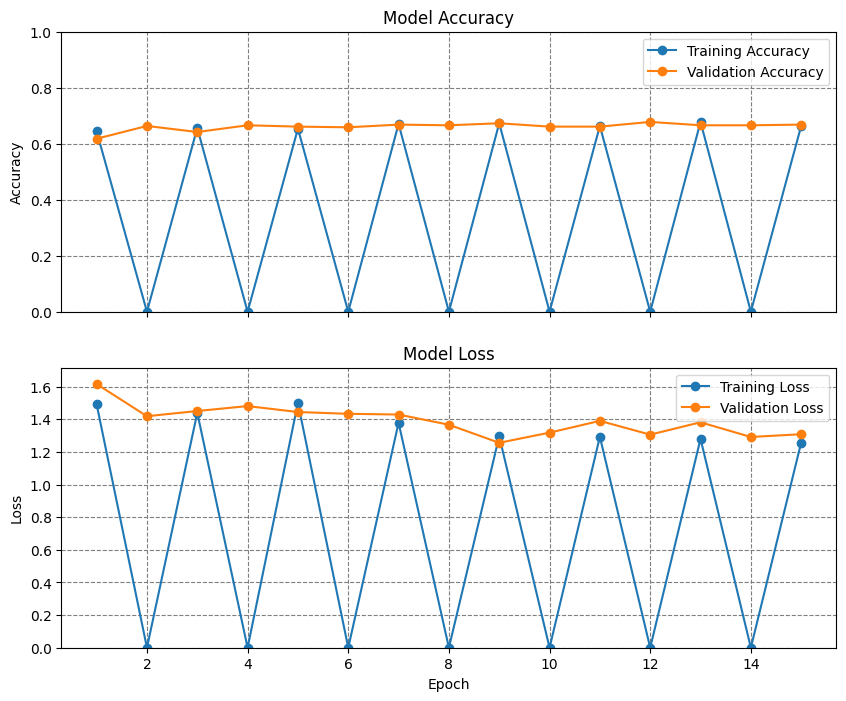

In [245]:
val_acc = history.history.get('val_accuracy', history.history.get('val_acc'))
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

x_plot = np.arange(1, len(acc) + 1)

# Accuracy plot
ax[0].plot(x_plot, acc, 'o-', label='Training Accuracy')
ax[0].plot(x_plot, val_acc, 'o-', label='Validation Accuracy')
ax[0].legend()
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('Model Accuracy')

# Loss plot
ax[1].plot(x_plot, loss, 'o-', label='Training Loss')
ax[1].plot(x_plot, val_loss, 'o-', label='Validation Loss')
ax[1].legend()
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0, max(max(loss), max(val_loss)) + 0.1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')

plt.show()


In [246]:
val_loss, val_accuracy = model.evaluate(val_batches_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7076 - loss: 1.2758


In [247]:
test_loss, test_accuracy = model.evaluate(test_batches_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3785 - loss: 2.4851


In [248]:
import os

# ✅ Create a "model" folder if it doesn't exist
os.makedirs("model", exist_ok=True)

# ✅ Save model inside your project directory
model.save("model/flood_detection_trained_model.h5")

print("✅ Model saved successfully at: model/flood_detection_trained_model.h5")


✅ Model saved successfully at: model/flood_detection_trained_model.h5
